In [2]:
# from   pathlib      import Path
# import importlib

# import numpy                as np
# import matplotlib           as mpl
# import matplotlib.pyplot    as plt
# import seaborn              as sns
# import pandas               as pd

# from scipy.stats   import kruskal, wilcoxon, mannwhitneyu, ranksums
# from scipy.optimize import curve_fit
# import statsmodels.api as sm
# from statsmodels.multivariate.manova import MANOVA
# import statsmodels.formula.api as smf
# from eidynamics     import utils, plot_tools
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 12
# plt.rcParams['svg.fonttype'] = 'none'

# # make a colour map viridis
# viridis = mpl.colormaps["viridis"]
# flare   = mpl.colormaps["flare"]
# crest   = mpl.colormaps["crest"]
# magma   = mpl.colormaps["magma"]
# edge    = mpl.colormaps['edge']

# color_E = "flare"
# color_I = "crest"
# color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
# color_squares = color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
# color_EI = {-70:flare(0), 0:crest(0)}
# colors_EI = {-70:flare, 0:crest}

# Fs = 2e4
# %matplotlib widget
# freq_sweep_pulses = np.arange(9)

# from eidynamics.fit_PSC     import find_sweep_expected
# # from Findsim        import tab_presyn_patterns_LR_43
# # import parse_data
# from eidynamics     import utils, plot_tools
# import all_cells
# # import plotFig2
# import stat_annotate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import plotFig2
%colors nocolor
Fs=2e4

In [13]:
# load data
figure_raw_material_location = Path(r"paper_figure_matter\\")
paper_figure_export_location = Path(r"paper_figures\\Figure2v2\\")
data_path                    = Path(r"parsed_data\\")

# Load the dataset
freq_sweep_vc_datapath =  Path(r"parsed_data\\all_cells_FreqSweep_VC_long.h5")
df = pd.read_hdf(freq_sweep_vc_datapath, key='data')

# # expanded dataframe (processed dataframe with metadata and analysed params)
# expanded_data_path = Path(r"parsed_data\all_cells_FreqSweep_combined_expanded.h5")
# xc_FS_analyseddf = pd.read_hdf(expanded_data_path, key='data')

In [14]:
df.shape

(4407, 80073)

In [15]:
# remove columns that are not needed
# not needed columns are 20049 to 80049
df = df.drop(df.columns[20049:80049], axis=1)
df.shape

(4407, 20073)

In [16]:
import importlib
importlib.reload(plotFig2)

new_fields = ['valley_', 'valleytime_', 'peak_', 'peaktime_', 'slope_', 'delay_', 'normpeak_', 'PSC_']
newcolumns = [field + str(i) for field in new_fields for i in range(9)]
Fs=2e4
# Adding new columns with NaN values
df = df.assign(**{col: np.nan for col in newcolumns})
c = 0
for idx, row in df.iterrows():
    # do no process if freq==10
    if row['stimFreq'] <20:
        c+=1
        continue
    if row['probePulseStart'] == row['pulseTrainStart']:
        c+=1
        continue
    
    results = plotFig2.deconv(row[49:80049], row['stimFreq'], row['probePulseStart'], row['pulseTrainStart'], None, noprobepulse=False)
    
    valleyTimes, valleys, peakTimes, peaks = results[2]
    # elementwise difference between peak and valley is PSC
    pscs = np.array(peaks) - np.array(valleys)  
    normpeaks = np.array(peaks) / peaks[0]
    stimTimes = np.array(results[-1]) / Fs    
    slopes = np.array([(peaks[i] - valleys[i]) / (peakTimes[i] - valleyTimes[i]) for i in range(len(peaks))])
    delays = np.array([(valleyTimes[i] - stimTimes[i]) for i in range(len(valleyTimes))])

    for col in newcolumns:
        prefix, col_idx = col.split('_')
        col_idx = int(col_idx)

        if col_idx < len(valleys):  # Ensure index is within bounds
            if prefix == 'valley':
                df.loc[row.name, col] = valleys[col_idx]
            elif prefix == 'valleytime':
                df.loc[row.name, col] = valleyTimes[col_idx]
            elif prefix == 'peak':
                df.loc[row.name, col] = peaks[col_idx]
            elif prefix == 'peaktime':
                df.loc[row.name, col] = peakTimes[col_idx]
            elif prefix == 'slope':
                df.loc[row.name, col] = slopes[col_idx]
            elif prefix == 'delay':
                df.loc[row.name, col] = delays[col_idx]
            elif prefix == 'normpeak':
                df.loc[row.name, col] = normpeaks[col_idx]
            elif prefix == 'PSC':
                df.loc[row.name, col] = pscs[col_idx]

    # counter for every 100 rows
    if idx % 100 == 0:
        print(f"Processed {idx} rows")

# Assuming df is your final DataFrame
metadata_cols1 = df.iloc[:, :49]
metadata_cols2 = df.iloc[:, 20049:]

# Concatenating the two slices into a new DataFrame
new_df = pd.concat([metadata_cols1, metadata_cols2], axis=1)

# Display the shape of the new DataFrame to verify
print(new_df.shape)
print(f"Skipped {c} rows")


Processed 0 rows


c:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\plotFig2.py:48: RuntimeWarning: overflow encountered in exp
  ret, cov = sci.curve_fit(lambda t,a,tau: a*np.exp(-t/tau), x, y, p0=(pk-baseline,0.02) )
c:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\plotFig2.py:48: RuntimeWarning: overflow encountered in multiply
  ret, cov = sci.curve_fit(lambda t,a,tau: a*np.exp(-t/tau), x, y, p0=(pk-baseline,0.02) )
c:\venvs\venv-ephys\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Processed 100 rows
Processed 200 rows
Processed 300 rows
Processed 400 rows
Processed 500 rows
Processed 600 rows
Processed 700 rows
Processed 800 rows
Processed 900 rows
Processed 1000 rows
Processed 1100 rows
Processed 1200 rows
Processed 1300 rows
Processed 1400 rows
Processed 1500 rows
Processed 1900 rows
Processed 2000 rows
Processed 2100 rows
Processed 2200 rows
Processed 2300 rows
Processed 2400 rows
Processed 2500 rows
Processed 2600 rows
Processed 2700 rows
Processed 2800 rows
Processed 2900 rows
Processed 3000 rows
(4407, 145)
Skipped 1635 rows


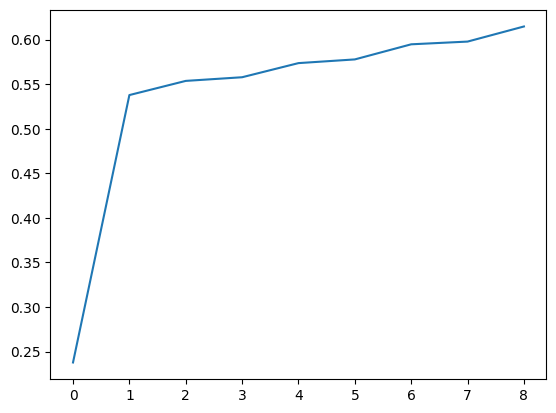

In [22]:
plt.figure()
plt.plot( results[2][2] )

In [18]:
print(new_df.shape)
# save df
new_df.to_hdf(data_path / "all_cells_FreqSweep_VC_kernelfit_response_measurements.h5", key='data', mode='w')
# save as excel
new_df.to_excel(data_path / "all_cells_FreqSweep_VC_kernelfit_response_measurements.xlsx")

# drop those rows from df that have NaN values in column 'valley_0'
new_df = new_df.dropna(subset=['valley_0'])
print(new_df.shape)


(4407, 145)


C:\Users\adity\AppData\Local\Temp\ipykernel_31428\2517785655.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block5_values] [items->Index(['sex', 'unit', 'location', 'protocol', 'numSq', 'clampMode',
       'clampPotential', 'condition', 'numPatterns', 'patternList',
       'frameChangeTimes', 'pulseTimes', 'fieldData', 'peaks_cell',
       'peaks_cell_norm', 'auc_cell', 'slope_cell', 'delay_cell',
       'peaks_field', 'peaks_field_norm', 'cell_fpr', 'field_fpr', 'cell_ppr',
       'cell_stpr', 'field_ppr', 'field_stpr', 'trialID', 'cellunit',
       'fieldunit'],
      dtype='object')]

  new_df.to_hdf(data_path / "all_cells_FreqSweep_VC_kernelfit_response_measurements.h5", key='data', mode='w')


(2772, 145)


In [19]:
# save df
new_df.to_hdf(data_path / "all_cells_FreqSweep_VC_kernelfit_response_measurements_noNANs.h5", key='data', mode='w')
# save as excel
new_df.to_excel(data_path / "all_cells_FreqSweep_VC_kernelfit_response_measurements_noNANs.xlsx")

C:\Users\adity\AppData\Local\Temp\ipykernel_31428\1705529343.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block5_values] [items->Index(['sex', 'unit', 'location', 'protocol', 'numSq', 'clampMode',
       'clampPotential', 'condition', 'numPatterns', 'patternList',
       'frameChangeTimes', 'pulseTimes', 'fieldData', 'peaks_cell',
       'peaks_cell_norm', 'auc_cell', 'slope_cell', 'delay_cell',
       'peaks_field', 'peaks_field_norm', 'cell_fpr', 'field_fpr', 'cell_ppr',
       'cell_stpr', 'field_ppr', 'field_stpr', 'trialID', 'cellunit',
       'fieldunit'],
      dtype='object')]

  new_df.to_hdf(data_path / "all_cells_FreqSweep_VC_kernelfit_response_measurements_noNANs.h5", key='data', mode='w')
